# CIFAR 분류기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import wandb
import gc

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from sklearn.metrics import accuracy_score

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)
random_seed(42)

In [3]:
device = torch.device('mps')

In [5]:
wandb.login(key='')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: greedjar74 (greedjar7498). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/kimhongseok/.netrc


# Data

In [4]:
# 데이터 불러오기
cifar_transform = T.Compose([
    T.ToTensor(), # 텐서 형식으로 변환
])
download_root = './CIFAR10_DATASET'

trainval_dataset = torchvision.datasets.CIFAR10(download_root, transform=cifar_transform, train=True, download=True) # train dataset 다운로드
test_dataset = torchvision.datasets.CIFAR10(download_root, transform=cifar_transform, train=False, download=True) # test dataset 다운로드

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_num, valid_num = int(len(trainval_dataset) * 0.8), int(len(trainval_dataset) * 0.2) # 8 : 2 = train : valid
print("Train dataset 개수 : ",train_num)
print("Validation dataset 개수 : ",valid_num)
train_dataset,val_dataset = torch.utils.data.random_split(trainval_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset 개수 :  40000
Validation dataset 개수 :  10000


In [6]:
BATCH_SIZE = 500 # 배치사이즈 설정
# 데이터로더 설정
ae_train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=False, num_workers = 8) # train dataloader 구성
ae_val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          drop_last=False, num_workers = 8) # valid dataloader 구성
ae_test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          drop_last=False, num_workers = 8) # test dataloader 구성

In [7]:
BATCH_SIZE = 1000 # 배치사이즈 설정
# 데이터로더 설정
clf_train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=False, num_workers = 8) # train dataloader 구성
clf_val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          drop_last=False, num_workers = 8) # valid dataloader 구성
clf_test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          drop_last=False, num_workers = 8) # test dataloader 구성

In [8]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

# Autoencoder Model

In [9]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=3*32*32, out_features=2048),
            torch.nn.BatchNorm1d(num_features=2048),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=2048, out_features=1024),
            torch.nn.BatchNorm1d(num_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=512),
            torch.nn.BatchNorm1d(num_features=512),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=512, out_features=256),
            torch.nn.BatchNorm1d(num_features=256),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(in_features=256, out_features=64),
            torch.nn.BatchNorm1d(num_features=64),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(in_features=64, out_features=16),
            torch.nn.ReLU(True)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(in_features=16, out_features=64),
            torch.nn.BatchNorm1d(num_features=64),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=64, out_features=256),
            torch.nn.BatchNorm1d(num_features=256),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=256, out_features=512),
            torch.nn.BatchNorm1d(num_features=512),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=512, out_features=1024),
            torch.nn.BatchNorm1d(num_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=2048),
            torch.nn.BatchNorm1d(num_features=2048),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(in_features=2048, out_features=3*32*32),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
ae_model = AutoEncoder()
summary(ae_model, input_size=(3, 32, 32))

del ae_model
gc.collect()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2048]       6,293,504
       BatchNorm1d-2                 [-1, 2048]           4,096
              ReLU-3                 [-1, 2048]               0
            Linear-4                 [-1, 1024]       2,098,176
       BatchNorm1d-5                 [-1, 1024]           2,048
              ReLU-6                 [-1, 1024]               0
            Linear-7                  [-1, 512]         524,800
       BatchNorm1d-8                  [-1, 512]           1,024
              ReLU-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
      BatchNorm1d-11                  [-1, 256]             512
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                   

0

# Classifier Model

In [11]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            torch.nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, padding=1, stride=1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=16*16*128, out_features=2048),
            torch.nn.BatchNorm1d(num_features=2048),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=2048, out_features=1024),
            torch.nn.BatchNorm1d(num_features=1024),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=1024, out_features=256),
            torch.nn.BatchNorm1d(num_features=256),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=256, out_features=64),
            torch.nn.BatchNorm1d(num_features=64),
            torch.nn.ReLU(True),
            torch.nn.Linear(in_features=64, out_features=10),
            torch.nn.LogSoftmax(dim=1)
        )

    
    def forward(self, x):
        x = x.view(-1, 3, 32, 32)
        outputs = self.layer(x)
        return outputs

In [12]:
clf_model = Classifier()
summary(clf_model, input_size=(1, 32*32*3))

del clf_model
gc.collect()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          36,992
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

0

# training

In [36]:
run1 = wandb.init(project='CIFAR_10', name='AutoEncoder training')
run2 = wandb.init(project='CIFAR_10', name='Classifier training')

In [13]:
def ae_training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs, device):
    model.train()
    ae_train_loss = 0.0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        # labels = labels.to(device)

        y = images.view(images.size(0), -1)
        encoded, decoded = model(images)
        loss = criterion(decoded, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ae_train_loss += loss.item()
        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    ae_train_loss = ae_train_loss / len(train_dataloader)

    return model, ae_train_loss

def ae_training_loop(model, train_dataloader, train_dataset, criterion, optimizer, num_epochs, device):
    model.to(device)
    for epoch in range(num_epochs):
        model, ae_train_loss = ae_training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs, device)

        # monitoring_value = {'Train Loss': ae_train_loss}
        # run1.log(monitoring_value, step=epoch)

    return model

def clf_training(model, ae_model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs, device):
    model.train()
    ae_model.eval()
    clf_train_loss = 0.0
    clf_train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        labels = labels.to(device)

        encoded, decoded = ae_model(images)
        outputs = model(decoded)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        clf_train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        clf_train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    clf_train_loss = clf_train_loss / len(train_dataloader)
    clf_train_accuracy = clf_train_accuracy / len(train_dataset)

    return model, clf_train_loss, clf_train_accuracy

def clf_training_loop(model, ae_model, train_dataloader, train_dataset, criterion, optimizer, num_epochs, device):
    model.to(device)
    ae_model.to(device)

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = clf_training(model, ae_model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs, device)

        # monitoring_value = {'Train Loss': train_loss, 'Train Accuracy': train_accuracy}
        # run2.log(monitoring_value, step=epoch)

    return model

In [14]:
ae_model = AutoEncoder()
clf_model = Classifier()

ae_criterion = torch.nn.MSELoss()
clf_criterion = torch.nn.NLLLoss()

ae_optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)
clf_optimizer = torch.optim.Adam(clf_model.parameters(), lr=0.001)

ae_model = ae_training_loop(ae_model, ae_train_dataloader, train_dataset, ae_criterion, ae_optimizer, 10, device)
clf_model = clf_training_loop(clf_model, ae_model, clf_train_dataloader, train_dataset, clf_criterion, clf_optimizer, 10, device)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

# test

In [15]:
ae_model.eval()
ae_model.to(device)

total_images = []
total_decoded = []

with torch.no_grad():
    tbar = tqdm(ae_test_dataloader)
    for images, labels in tbar:
        images = images.to(device)
        
        encoded, decoded = ae_model(images)

        total_images.extend(images)
        total_decoded.extend(decoded)

  0%|          | 0/20 [00:00<?, ?it/s]

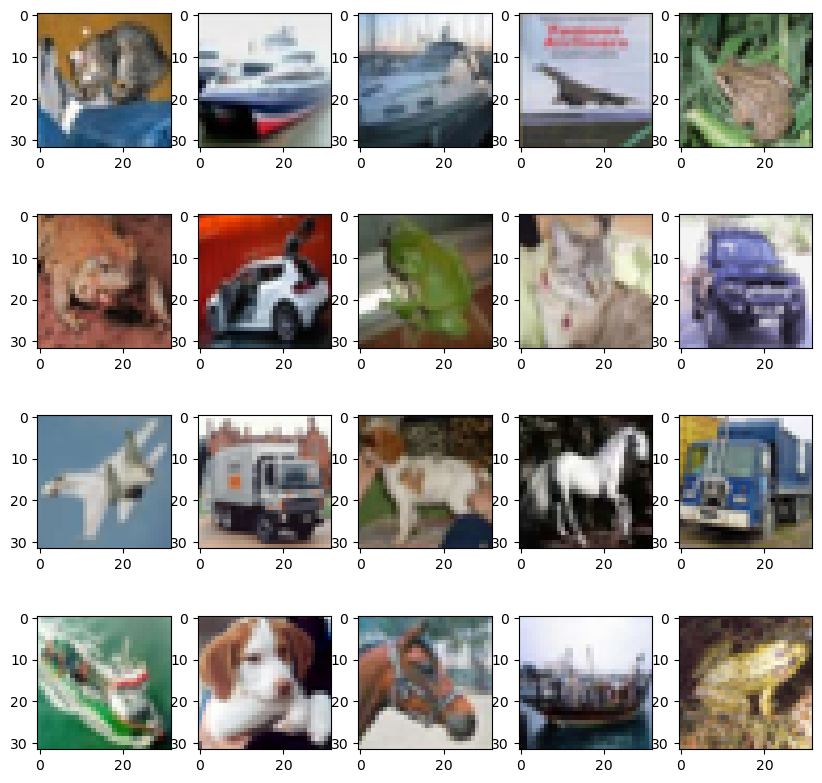

In [21]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_images[i].cpu().permute((1, 2, 0))))

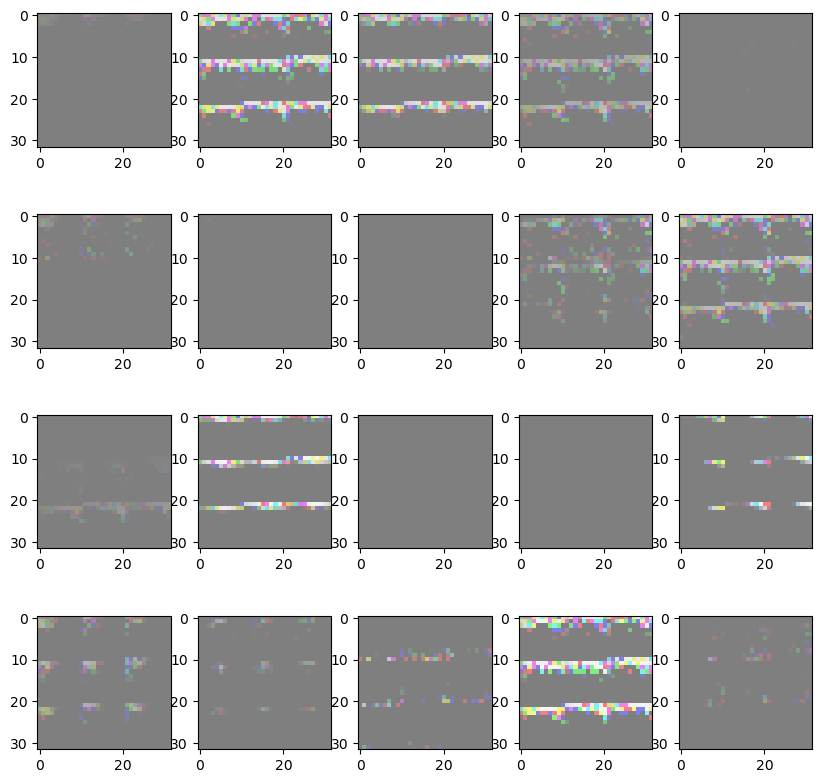

In [24]:
plt.figure(figsize=(10, 10))

for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(np.array(total_decoded[i].cpu().view(32, 32, 3)))